<a href="https://colab.research.google.com/github/kenanmorani/Reinforcement_Learning_idu/blob/main/Gym_Envs_MountainCar_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reinforcement Learning Final Project  
Izmir Democracy University, Electrical and Electronics Program  
By Kenan Morani  
Supervised by Assoc. Prof. Dr. Selami Beyhan  
Presented on 11.02.2021

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
# Importing the required libraries
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

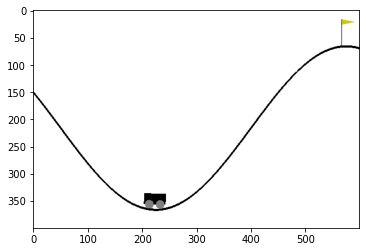

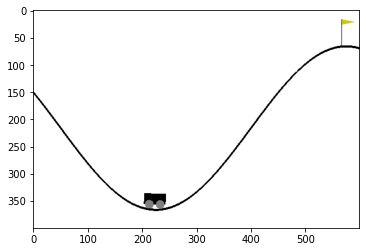

In [5]:
env = gym.make('MountainCar-v0')
env.reset()

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

## Actions & States

In [6]:
# Checking number of actions in the environment
print(env.action_space.n)
 
# Intially checking the stats and rewards in the environment
state = env.reset()

3


Three actions in the environemnt:    
 Action 0. push car left   
 Action 1. do nothin  
 Action 2. push car right

States are: position and velocity

In [7]:
# The range of values for observations (Velocity&Speed)
print(env.observation_space.high) # High values for all possible observations
print(env.observation_space.low) # Low values for all possible observations

[0.6  0.07]
[-1.2  -0.07]


In [10]:
# Checking intial rewards and states
done = False
while not done:
    action = 2 # Randomly chosing action 2 (push the car right) 
    new_state, reward, done, _ = env.step(action) 
    print(reward, new_state)
    env.render()

-1.0 [-0.33368059 -0.00585469]


* The initial rewards are all -1 meaning that the car has not yet reached the optimal reward of 0, when it reaches the flag on top.

In [39]:
# Descritizing the observation range with 40 chanks
DISCRETE_OS_SIZE = [40] * len(env.observation_space.high)
# The window size between high and low values
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE 
# [Position Velocity] chunks (equal dividing bits lengths)
print(discrete_os_win_size) 

[0.045  0.0035]


## Initializing Q-table

In [40]:
#Intializing Qtable
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n])) 
print(q_table.shape)

(40, 40, 3)


* Coluomns of the Qtable are the size of 3 (number of actions)  
* Rows of the table are the size of each combination possible from position*velocity which is chosen to be 20X20 matrics
* All in all the Qtable consists of 40X40X3 matrixes (All possible combinations)

In [41]:
print(q_table)

[[[-0.87257327 -1.99706422 -0.2915009 ]
  [-1.06311835 -0.93063359 -0.78947425]
  [-1.73288067 -1.55966517 -1.93813746]
  ...
  [-0.39162509 -1.34955075 -0.14308846]
  [-0.38415482 -1.2250353  -1.81823437]
  [-0.18456924 -1.67714641 -0.3648741 ]]

 [[-0.67835298 -0.04657395 -1.74077586]
  [-1.28882763 -0.61228017 -1.95594084]
  [-0.3736168  -0.87013937 -0.16889945]
  ...
  [-1.39409556 -1.11003039 -1.4960771 ]
  [-1.28219745 -0.32443387 -0.41502373]
  [-0.62769905 -1.74886261 -0.10632698]]

 [[-1.80133559 -0.86312203 -0.4184035 ]
  [-0.88140152 -1.92479674 -0.81892849]
  [-0.62174816 -1.0653813  -0.37602218]
  ...
  [-0.04286614 -0.88865084 -1.22221557]
  [-1.28425321 -0.25486569 -1.30215874]
  [-1.09451841 -0.93786956 -0.84169387]]

 ...

 [[-0.96825787 -1.63406705 -0.14139768]
  [-0.56906802 -1.47848269 -1.30862676]
  [-0.72306576 -0.88128316 -1.30281923]
  ...
  [-0.13681537 -1.38719719 -1.97613389]
  [-1.48284722 -0.51873009 -0.55379726]
  [-0.38043742 -0.72770005 -0.44581424]]

 [

In [28]:
# For stats
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

# Updating Qtable values

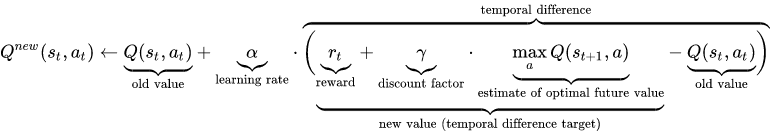

* https://en.wikipedia.org/wiki/Q-learning

In [42]:
# Defining Constants
LEARNING_RATE = 0.1
DISCOUNT = 0.95 # Measure of how important feature actions versus current actions are
EPISODES = 20000 # Number of iterations
SHOW_EVERY = 500 # İnform us that you are still working to reach the top evert 2000 episodes

In [43]:
# we use this tuple to look up the 3 Q values for the available actions in the q-table
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))  
discrete_state = get_discrete_state (env.reset())
print(discrete_state)
print(np.argmax(q_table[discrete_state])) # Understanding the max Q value in the Q-table

(15, 20)
0


In [44]:
# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

In [45]:
# Running the epoches to reach the goal
for episode in range(EPISODES):
    episode_reward = 0
    discrete_state = get_discrete_state(env.reset())
    done = False

    if episode % SHOW_EVERY == 0:
        render = True
        print(episode)
    else:
        render = False

    while not done:

        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)


        new_state, reward, done, _ = env.step(action)

        episode_reward += reward
        new_discrete_state = get_discrete_state(new_state)

        if episode % SHOW_EVERY == 0:
            env.render()
        #new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

        # If simulation did not end yet after last step - update Q table
        if not done:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q
            
        # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        elif new_state[0] >= env.goal_position:
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    ep_rewards.append(episode_reward)
    if not episode % SHOW_EVERY:
        average_reward = sum(ep_rewards[-SHOW_EVERY:])/SHOW_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')
env.close()

0
Episode:     0, average reward: -137.1, current epsilon: 1.00
500
Episode:   500, average reward: -200.0, current epsilon: 0.95
1000
Episode:  1000, average reward: -200.0, current epsilon: 0.90
1500
Episode:  1500, average reward: -200.0, current epsilon: 0.85
2000
Episode:  2000, average reward: -200.0, current epsilon: 0.80
2500
Episode:  2500, average reward: -200.0, current epsilon: 0.75
3000
Episode:  3000, average reward: -200.0, current epsilon: 0.70
3500
Episode:  3500, average reward: -200.0, current epsilon: 0.65
4000
Episode:  4000, average reward: -200.0, current epsilon: 0.60
4500
Episode:  4500, average reward: -200.0, current epsilon: 0.55
5000
Episode:  5000, average reward: -200.0, current epsilon: 0.50
5500
Episode:  5500, average reward: -199.8, current epsilon: 0.45
6000
Episode:  6000, average reward: -199.2, current epsilon: 0.40
6500
Episode:  6500, average reward: -198.7, current epsilon: 0.35
7000
Episode:  7000, average reward: -196.1, current epsilon: 0.30

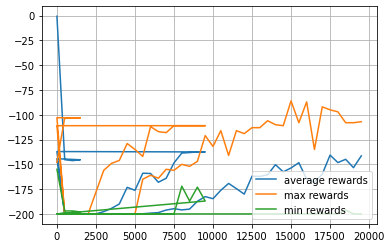

In [47]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.grid(True)
plt.show()